In [1]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa, librosa.display
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from IPython.display import Audio
from io import StringIO

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!wget https://drive.google.com/open?id=0B1EIpliBTjj9MzhiYXVrdEdwRzA -O genres.tar.gz 
!tar -xzf genres.tar.gz 

--2017-11-21 12:11:22--  https://drive.google.com/open?id=0B1EIpliBTjj9MzhiYXVrdEdwRzA
Resolving drive.google.com... 173.194.222.194, 2a00:1450:4010:c0b::c2
Connecting to drive.google.com|173.194.222.194|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/0B1EIpliBTjj9MzhiYXVrdEdwRzA/view?usp=drive_web [following]
--2017-11-21 12:11:23--  https://drive.google.com/file/d/0B1EIpliBTjj9MzhiYXVrdEdwRzA/view?usp=drive_web
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'genres.tar.gz'

genres.tar.gz           [ <=>                ]  38.50K  --.-KB/s    in 0.09s   

2017-11-21 12:11:23 (435 KB/s) - 'genres.tar.gz' saved [122363]

tar: Unrecognized archive format
tar: Error exit delayed from previous errors.


In [2]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}'></audio>".format(url))

In [3]:
sound_file = './genres/blues/blues.00000.au'

y, sr = librosa.load(sound_file)
librosa.output.write_wav('./genres/tmp.wav', y, sr, norm=True)
Audio(url='./genres/tmp.wav')

# Sound as 1D-Signal

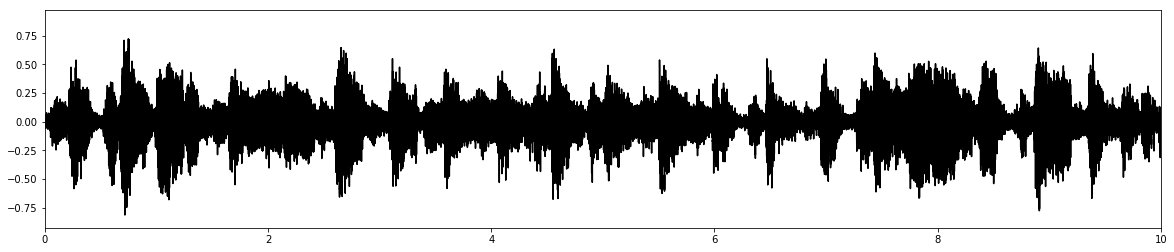

In [4]:
plt.figure(figsize=(20,4))
pylab.plot(np.arange(len(y)) * 1.0 /sr, y, 'k')
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

In [5]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

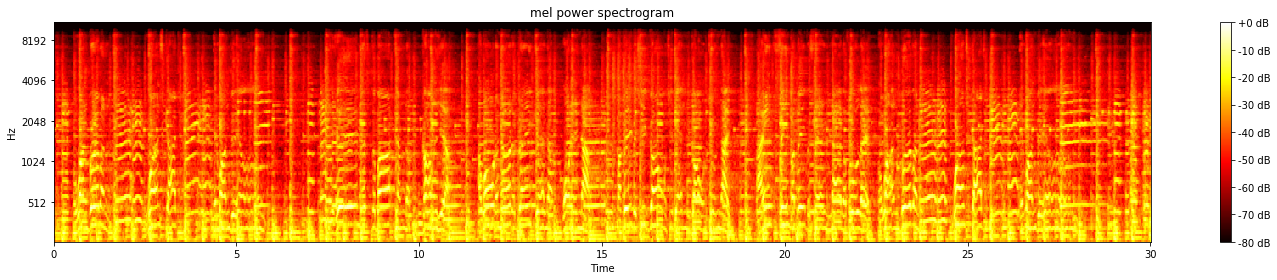

In [6]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [7]:
def get_spectgorgamm(fname):
    y, sr = librosa.load(fname)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.logamplitude(S, ref_power=np.max)
    
    return log_S[:, :1200]

def plot_spectrogramm(log_S):
    plt.figure(figsize=(20,4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
    plt.title('mel power spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

# Prepare a data

In [8]:
geners = ['blues', 'country', 'hiphop', 'metal', 'reggae', 'classical', 'disco', 'jazz', 'pop', 'rock']

id2gener = dict()
X_names, y = [], []
for gener_id, gener in enumerate(geners):
    id2gener[gener_id] = gener
    for track in os.listdir('./genres/' + gener):
        if '.mp3' in track or '.au' in track and '_' not in track:
            trackfile = os.path.join('./genres/', gener, track)
            X_names.append(trackfile)
            y.append(gener_id)

In [9]:
from multiprocessing import Pool

ncpu = 4
X = Pool(ncpu).map(get_spectgorgamm, X_names)

Process ForkPoolWorker-3:
Traceback (most recent call last):
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/s.latatye/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/s.latatye/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/s.latatye/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/s.latatye/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/s.latatye/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/s.latatye/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "

# Nearest Neighbors genre classification

In [10]:
perm = np.random.permutation(len(y))
X, X_names, y = np.array(X)[perm].astype('float32'), np.array(X_names)[perm], np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:800], Xreshape[800:]
y_train, y_valid = y[:800], y[800:]

In [11]:
X_train.shape

(800, 128, 1200)

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=ncpu)

clf.fit(X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2])), y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])))

print (accuracy_score(y_valid, y_val_pred))

0.34


# Convolution Nural Nets

![](http://benanne.github.io/images/spotify_convnet.png)

http://benanne.github.io/2014/08/05/spotify-cnns.html

In [13]:
import theano
import lasagne
import theano.tensor as T

In [14]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:800], Xreshape[800:]
y_train, y_valid = y[:800], y[800:]

input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = lasagne.layers.Conv1DLayer(nn, num_filters = 4, filter_size = 3, nonlinearity = T.nnet.relu)
nn = lasagne.layers.MaxPool1DLayer(nn, pool_size = 4)
nn = lasagne.layers.Conv1DLayer(nn, num_filters = 4, filter_size = 3, nonlinearity = T.nnet.relu)
nn = lasagne.layers.MaxPool1DLayer(nn, pool_size = 1)
nn = lasagne.layers.Conv1DLayer(nn, num_filters = 4, filter_size = 3, nonlinearity = T.nnet.relu)
nn = lasagne.layers.MaxPool1DLayer(nn, pool_size = 2)
nn = lasagne.layers.Conv1DLayer(nn, num_filters = 4, filter_size = 3, nonlinearity = T.nnet.relu)

nn = lasagne.layers.DenseLayer(nn, num_units = 2048, nonlinearity = T.nnet.relu)
nn = lasagne.layers.DenseLayer(nn, num_units = 2048, nonlinearity = T.nnet.relu)
nn = lasagne.layers.DropoutLayer(nn, p = 0.1)
nn = lasagne.layers.DenseLayer(nn, 10, nonlinearity=lasagne.nonlinearities.softmax)

In [26]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.sgd(loss, all_weights, learning_rate=0.1)

In [27]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [28]:
%%time 

conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

Epoch   1 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 9.25 val_acc = 8.00
Epoch   2 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 9.75 val_acc = 7.00
Epoch   3 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.88 val_acc = 7.00
Epoch   4 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.50 val_acc = 7.00
Epoch   5 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.88 val_acc = 6.50
Epoch   6 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.63 val_acc = 7.00
Epoch   7 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 9.25 val_acc = 7.00
Epoch   8 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 9.88 val_acc = 7.00
Epoch   9 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.50 val_acc = 7.00
Epoch  10 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.25 val_acc = 7.00
Epoch  11 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.75 val_acc = 7.00
Epoch  12 of  32 train_loss = 2.30 val_loss = 2.31 train_acc = 10.75 val_acc = 7

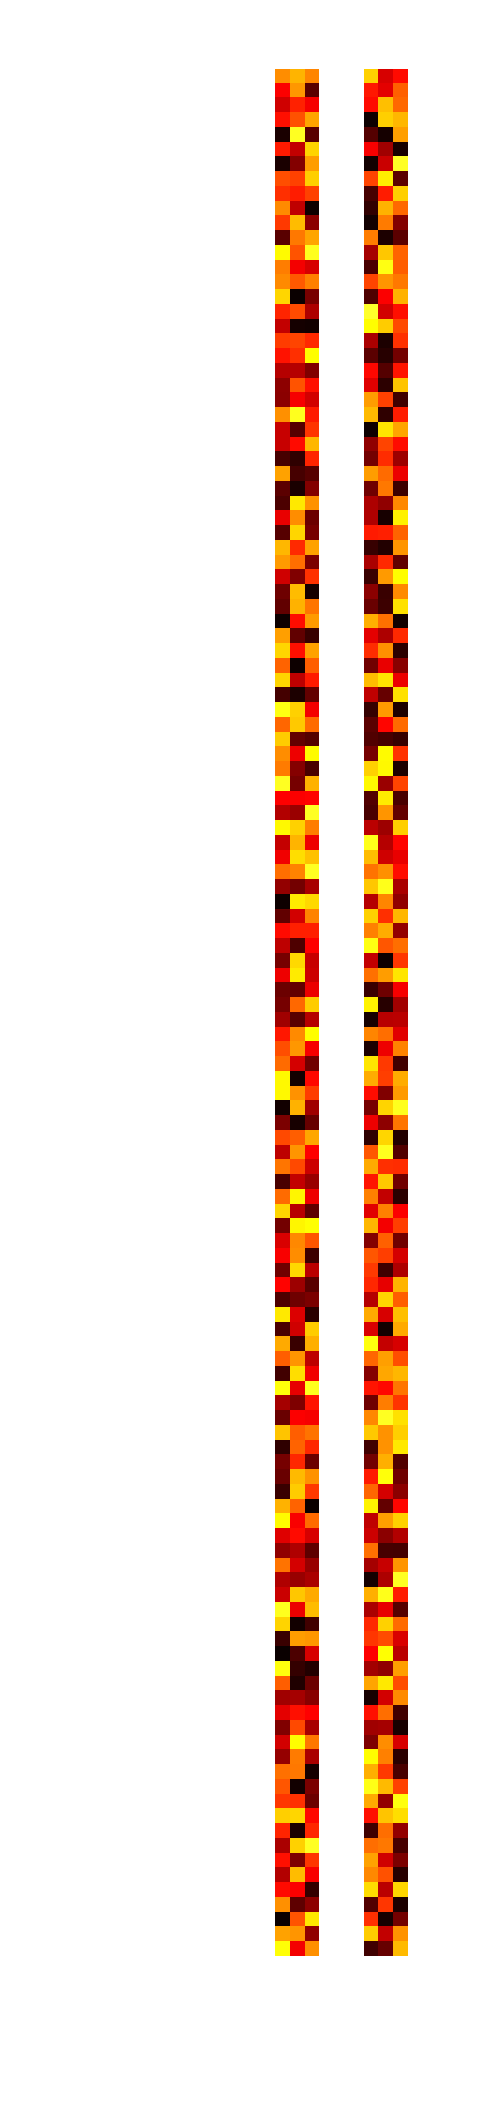

In [29]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Find Simular Tracks

<img src="./img/cnn_gr.png" width="500">

In [30]:
from sklearn.neighbors import NearestNeighbors

In [31]:
represent = lasagne.layers.get_output(nn)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [32]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = list(map(f, X_train)) + list(map(f, X_valid))
track_vectors = np.concatenate(track_vectors, axis=0)

In [33]:
track_vectors[0].reshape(1, -1)

array([[ 0.09912781,  0.09381085,  0.10512156,  0.09605923,  0.10380052,
         0.09520926,  0.10637895,  0.09750271,  0.09563904,  0.10735007]])

In [34]:
nn_pred = NearestNeighbors(metric='cosine', algorithm='brute')

In [35]:
nn_pred = nn_pred.fit(track_vectors)

In [36]:
X_names[0]

'./genres/rock/rock.00053.au'

In [37]:
ans = list(X_names[nn_pred.kneighbors(track_vectors[0].reshape(1, -1))[1][0]])
ans

['./genres/rock/rock.00053.au',
 './genres/metal/metal.00054.au',
 './genres/blues/blues.00043.au',
 './genres/rock/rock.00035.au',
 './genres/classical/classical.00027.au']

In [38]:
sound_file = ans[0]
y, sr = librosa.load(sound_file)
librosa.output.write_wav('./genres/tmp.wav', y, sr, norm=True)
Audio(url='./genres/tmp.wav')

In [39]:
sound_file = ans[1]
y, sr = librosa.load(sound_file)
librosa.output.write_wav('./genres/tmp.wav', y, sr, norm=True)
Audio(url='./genres/tmp.wav')

# Maps of tracks by svd and tsne

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [77]:
from sklearn.manifold import TSNE

In [78]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [80]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = list(map(f, X_train)) + list(map(f, X_valid))
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

In [ ]:
X_tsne = <Make TSNE Features>

In [ ]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(X_tsne[:, 0][idx_], X_tsne[:, 1][idx_], c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc=0, ncol=5)